# TP de datos personales

## infovis, 1c2024

Alumno: Pedro Lopez Guzman

In [ ]:
!pip install altair
!pip install pandas

In [ ]:
!pip install bokeh

In [ ]:
!pip install "holoviews[recommended]"
%env HV_DOC_HTML=true

In [136]:
import altair as alt
import pandas as pd
import json
from pprint import pprint

games = pd.read_json('https://pedro-uwu.github.io/infovis/TP1/data/owned_games_with_tags.json')

In [137]:
# Tiempo total de juego por juego

chart = alt.Chart(games).transform_calculate(
    hours = "datum.playtime_forever / 60"
).encode(
    x = alt.X("hours:Q", title="Tiempo (hours)"),
    y = alt.Y("name", sort ='-x', title="Juego"),
    text = alt.Text("hours:Q", format=".2f"),
    tooltip=alt.Tooltip("hours:Q", format=".2f")
).transform_window(
    rank = 'rank(playtime_forever)',
    sort = [alt.SortField('playtime_forever', order='descending')]
).transform_filter(
    (alt.datum.rank <= 20)
)
chart = chart.mark_bar() + chart.mark_text(align='left', dx=10)
chart.configure_axis(
    grid=False
).configure_view(
    stroke=None
).properties(
    title="Top 20 más jugados"
)

alt.LayerChart(...)

In [138]:
# Porcentaje de juegos que jugué vs no jugué

pie_chart = alt.Chart(games).transform_calculate(
    playtime_cat = "datum.playtime_forever > 0 ? 'Jugado' : 'Nunca Jugado'"
).transform_aggregate(
    count="count()",
    groupby=["playtime_cat"]
).encode(
    alt.Theta("count:Q"),
    alt.Color("playtime_cat:N", legend=alt.Legend(title="He jugado?")),
    tooltip=['playtime_cat:N', 'count:Q']
)

pie = pie_chart.mark_arc(radius=200)
pie.configure_axis(
    grid=False
).configure_view(
    stroke=None
).properties(
    title="Jugados vs. No jugados"
)

alt.Chart(...)

In [139]:
# Crear un nuevo dataframe con las categorías
game_tags_list = list()
for _, row in games.iterrows():
  game_name = row['name']
  game_playtime = row['playtime_forever']/(60*24)
  tags = row['tags']
  if len(tags) == 0:
    continue
  for t in tags:
    game_tags_list.append({"Name": game_name, "tag": t, "Playtime": game_playtime })

games_tags_df = pd.DataFrame(game_tags_list)
print(games_tags_df.head())

              Name           tag  Playtime
0  Team Fortress 2  Free to Play    0.0375
1  Team Fortress 2  Hero Shooter    0.0375
2  Team Fortress 2   Multiplayer    0.0375
3  Team Fortress 2           FPS    0.0375
4  Team Fortress 2       Shooter    0.0375


In [140]:
# Graficar las tags mas comunes
common_tags = alt.Chart(games_tags_df).transform_aggregate(
    Count="count()",
    groupby=["tag"]
).encode(
    x=alt.X("Count:Q", title="Cantidad de juegos"),
    y=alt.Y("tag:N", sort='-x', title="Categoría"),
    text=alt.Text("Count:Q"),
    tooltip="Count:Q"
).transform_window(
    rank="rank(Count)",
    sort=[alt.SortField("Count", order="descending")]
).transform_filter(
    (alt.datum.rank <= 20)
).properties(
    title="Cagtegorías más comunes"
)

common_tags = common_tags.mark_bar() + common_tags.mark_text(align='right', dx=-10, color="white")
common_tags.configure_axis(
    grid=False
).configure_view(
    stroke=None
)

alt.LayerChart(...)

In [141]:
import holoviews as hv
# Quiero ver cuáles son las categorías en las que más horas tengo jugadas
# Para eso quiero hacer una lista ordenada de la suma total por categoría y quedarme con el top 20
# Después, voy a quedarme con los juegos que tienen esa categoría, para ver cómo se reparten esas horas

cumulative_tags = games_tags_df.groupby('tag')["Playtime"].sum().reset_index().sort_values(by=['Playtime'], ascending=False).head(15)
cumulative_chart = alt.Chart(cumulative_tags).encode(
    x = alt.X("Playtime:Q", title="Horas Acumuladas"),
    y = alt.Y("tag:N", sort='-x', title="Categoría"),
    text = alt.Text("Playtime:Q", format="d"),
    tooltip=alt.Tooltip("Playtime:Q", format=".2f")
).transform_window(
    rank="rank(Playtime)",
    sort=[alt.SortField("Playtime", order="descending")]
).transform_filter(
    (alt.datum.rank <= 15)
)

cumulative_chart = cumulative_chart.mark_bar() + cumulative_chart.mark_text(align="right", dx = -5, color="white")
cumulative_chart.configure_axis(
    grid=False
).configure_view(
    stroke=None
).properties(
    title="Categorías más jugadas"
)




alt.LayerChart(...)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
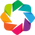

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)


:Sankey   [Source,Target]   (Value)

In [142]:
import holoviews as hv
hv.extension('bokeh')
graph = games_tags_df.copy().rename(columns={
    "Name": "Source",
    "Playtime": "Value",
    "tag": "Target"
})


graph = graph[graph["Target"].isin(cumulative_tags["tag"])]
graph = graph[graph["Value"] >= 1]


sankey = hv.Sankey(graph)
sankey.opts(title="", edge_color='Source', node_color='index')
# hv.save(sankey, "sankey.html", fmt="html")

## DuckDB

In [143]:
import duckdb
duckdb.sql("""SELECT name AS juego, (sum(playtime_forever)/60)::int AS horas
              FROM read_json('https://pedro-uwu.github.io/infovis/TP1/data/owned_games_with_tags.json')
              GROUP BY name
              ORDER BY horas DESC""").df().head(20)

,juego,horas
0,Dota 2,1572
1,Clicker Heroes,812
2,The Binding of Isaac: Rebirth,692
3,Counter-Strike 2,549
4,Cookie Clicker,349
5,Bloons TD 6,178
6,ELDEN RING,146
7,DARK SOULS™ III,133
8,PAYDAY 2,123
9,Realm of the Mad God Exalt,122


In [144]:
duckdb.sql("""SELECT name, tags
              FROM read_json('https://pedro-uwu.github.io/infovis/TP1/data/owned_games_with_tags.json')
             """).df().head(10)

,name,tags
0,Codename Gordon,[]
1,Team Fortress 2,"[Free to Play, Hero Shooter, Multiplayer, FPS,..."
2,Dota 2,"[Free to Play, MOBA, Multiplayer, Strategy, eS..."
3,Alien Swarm,"[Free to Play, Co-op, Action, Multiplayer, Onl..."
4,Source Filmmaker,"[Animation & Modeling, Free to Play, Video Pro..."
5,Sam & Max 104: Abe Lincoln Must Die!,"[Adventure, Point & Click, Cult Classic, 1990'..."
6,Age of Chivalry,"[Indie, Free to Play, Medieval, Action, Multip..."
7,Synergy,"[Free to Play, Co-op, Action, Mod, Multiplayer..."
8,D.I.P.R.I.P. Warm Up,"[Action, Racing, Indie, Free to Play, Mod, Mul..."
9,Eternal Silence,"[Action, Free to Play, Mod, FPS, Space, Sci-fi..."
